# **PRÉ-PROCESSAMENTO**

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
%matplotlib inline
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout
from sklearn.impute import SimpleImputer
from tensorflow.keras import backend as k 
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("MELBOURNE_HOUSE_PRICES_LESS.csv")
df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63018,Roxburgh Park,3 Carr Pl,3,h,566000.0,S,Raine,31/03/2018,3064,Northern Metropolitan,5833,20.6,Hume City Council
63019,Roxburgh Park,9 Parker Ct,3,h,500000.0,S,Raine,31/03/2018,3064,Northern Metropolitan,5833,20.6,Hume City Council
63020,Roxburgh Park,5 Parkinson Wy,3,h,545000.0,S,Raine,31/03/2018,3064,Northern Metropolitan,5833,20.6,Hume City Council
63021,Thomastown,3/1 Travers St,3,u,NaN,PI,Barry,31/03/2018,3074,Northern Metropolitan,7955,15.3,Whittlesea City Council


**Verificando se há dados nulos...**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         63023 non-null  object 
 1   Address        63023 non-null  object 
 2   Rooms          63023 non-null  int64  
 3   Type           63023 non-null  object 
 4   Price          48433 non-null  float64
 5   Method         63023 non-null  object 
 6   SellerG        63023 non-null  object 
 7   Date           63023 non-null  object 
 8   Postcode       63023 non-null  int64  
 9   Regionname     63023 non-null  object 
 10  Propertycount  63023 non-null  int64  
 11  Distance       63023 non-null  float64
 12  CouncilArea    63023 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 6.3+ MB


In [ ]:
df.isna().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price            14590
Method               0
SellerG              0
Date                 0
Postcode             0
Regionname           0
Propertycount        0
Distance             0
CouncilArea          0
dtype: int64

**Os dados nulos estão na target, vamos retira-lo pois não terá utilidade.**

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Postcode         0
Regionname       0
Propertycount    0
Distance         0
CouncilArea      0
dtype: int64

**Separando Features de Target:**

In [ ]:
X = df.drop(columns=["Price"])
y = df["Price"]

**Vimos que na coluna "Address" há o número de cada imóvel, vamos retirar pois os valores não são impactantes para o resultado de predição.**

In [ ]:
lista = []
for c in df["Address"]:
   lista.append(c.split(" ", 1)[1])
df["Address"] = lista

In [ ]:
df["Address"]

0           Lithgow St
1            Turner St
2             Yarra St
3              Vida St
4        Clydesdale Rd
             ...      
63016        Petrie St
63017        Murray Rd
63018          Carr Pl
63019        Parker Ct
63020     Parkinson Wy
Name: Address, Length: 48433, dtype: object

In [ ]:
df.head(2)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,0.0,7735.0,3,0.0,1490000.0,1.0,180.0,0.0,3067,2.0,4019,3.0,32.0
1,0.0,12829.0,3,0.0,1220000.0,1.0,225.0,0.0,3067,2.0,4019,3.0,32.0


In [ ]:
df["CouncilArea"].value_counts()

**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [ ]:
# "Suburb", "Address", "Type", "Date", "Method", "SellerG", "Regionname", "CouncilArea"
oe =  OrdinalEncoder()
oe.fit(df[["CouncilArea"]])


df["CouncilArea"] = oe.transform(df[["CouncilArea"]])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [ ]:
X = df.drop(columns=["Price"])
y = df["Price"]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48433 entries, 0 to 63020
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         48433 non-null  float64
 1   Address        48433 non-null  float64
 2   Rooms          48433 non-null  int64  
 3   Type           48433 non-null  float64
 4   Method         48433 non-null  float64
 5   SellerG        48433 non-null  float64
 6   Date           48433 non-null  float64
 7   Postcode       48433 non-null  int64  
 8   Regionname     48433 non-null  float64
 9   Propertycount  48433 non-null  int64  
 10  Distance       48433 non-null  float64
 11  CouncilArea    48433 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 4.8 MB


In [ ]:
ssc = StandardScaler()

ssc.fit(df[['Suburb', 'Address', 'Rooms', 'Type', 'Method', 'SellerG', "Date", 'Postcode', 'Regionname', 'Propertycount', 'Distance', 'CouncilArea' ]])
h= ssc.transform(df[['Suburb', 'Address', 'Rooms', 'Type', 'Method', 'SellerG', "Date", 'Postcode', 'Regionname', 'Propertycount', 'Distance', 'CouncilArea']])
df[['Suburb', 'Address', 'Rooms', 'Type', 'Method', 'SellerG',"Date", 'Postcode', 'Regionname', 'Propertycount', 'Distance', 'CouncilArea']] = h

# **DATASET BASE**

In [ ]:
X

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,0.0,7735.0,3,0.0,1.0,180.0,0.0,3067,2.0,4019,3.0,32.0
1,0.0,12829.0,3,0.0,1.0,225.0,0.0,3067,2.0,4019,3.0,32.0
2,0.0,13930.0,3,0.0,1.0,253.0,0.0,3067,2.0,4019,3.0,32.0
3,1.0,13039.0,3,0.0,1.0,28.0,0.0,3040,6.0,1543,7.5,22.0
4,2.0,2776.0,2,0.0,1.0,253.0,0.0,3042,6.0,3464,10.4,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...
63016,147.0,10212.0,2,2.0,3.0,14.0,88.0,3199,4.0,17055,38.0,7.0
63017,275.0,9254.0,3,0.0,1.0,305.0,88.0,3072,2.0,14577,8.4,6.0
63018,288.0,2283.0,3,0.0,1.0,306.0,88.0,3064,2.0,5833,20.6,11.0
63019,288.0,9991.0,3,0.0,1.0,306.0,88.0,3064,2.0,5833,20.6,11.0


In [ ]:
X = X
y = y

#====================================================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#====================================================================================================
def criarRede(optimizer='rmsprop', init='glorot_uniform'):
    #k.clear_session()
    rn = Sequential([
                #1ª camada oculta
               tf.keras.layers.Dense(units=7, activation = "relu", kernel_initializer = "random_uniform", input_dim=X_train.shape[1]), # input_dim = nº de colunas
               tf.keras.layers.Dropout(0.2),
                #2ª camada oculta
               tf.keras.layers.Dense(units=7, activation = "relu", kernel_initializer = "random_uniform"),
               tf.keras.layers.Dropout(0.2),
               #Camada de saída
               tf.keras.layers.Dense(units= 1, activation = 'linear')])
    

    rn.compile(optimizer = optimizer, loss = "mean_absolute_error", metrics = ['mean_absolute_error'])


    return rn
#====================================================================================================
kr = KerasRegressor(model=criarRede)

pipe = Pipeline([('kr', kr)])

# ==========================================================
#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Opitmização de Hiperparêmetros
params = {"kr__optimizer": ["adam"],
          "kr__batch_size": [10],
          "kr__epochs":[1000]} 
#====================================================================================================
#Motando a grade geral de parâmetros.
grid_kr = GridSearchCV(estimator=pipe,
                       param_grid=params,
                       scoring="neg_mean_absolute_error",
                       cv=splitter,
                       verbose=10)

grid_kr.fit(X_train, y_train)

In [ ]:
grid_kr.best_params_

{'kr__batch_size': 10, 'kr__epochs': 1000, 'kr__optimizer': 'adam'}

In [ ]:
grid_kr.best_score_

-1073.2014464052752

In [ ]:
y_pred = grid_kr.predict(X_test)

214/214 [==============================] - 0s 1ms/step


In [ ]:
y_pred

array([3419.5796, 2466.531 , 2727.5168, ..., 1553.6906, 3492.6978,
       1314.6624], dtype=float32)

In [ ]:
tabela = pd.DataFrame()

In [ ]:
tabela["Valor real"] = y_test

In [ ]:
tabela["Valor preditivo"] = y_pred

In [ ]:
tabela = tabela.sort_index()
tabela = tabela.reset_index()
tabela 

,index,Valor real,Valor preditivo
0,0,5618,5091.667480
1,3,1421,1372.781494
2,8,16440,14698.057617
3,10,2747,2555.168457
4,14,5343,4862.686523
...,...,...,...
2134,10665,1897,1858.879883
2135,10681,16040,14311.736328
2136,10682,4419,4052.685059
2137,10685,8726,7835.595703


In [ ]:
lista = []
for c in range(tabela.shape[0]):
  if tabela.loc[[c]].values[0][2] < tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][2] / tabela.loc[[c]].values[0][1])*100
      lista.append(valor)
  elif tabela.loc[[c]].values[0][2] > tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][1] / tabela.loc[[c]].values[0][2])*100
      lista.append(valor)
media = np.mean(lista)
print(f"Teve uma média de acerto de {media:.2f}%")

Teve uma média de acerto de 91.27%


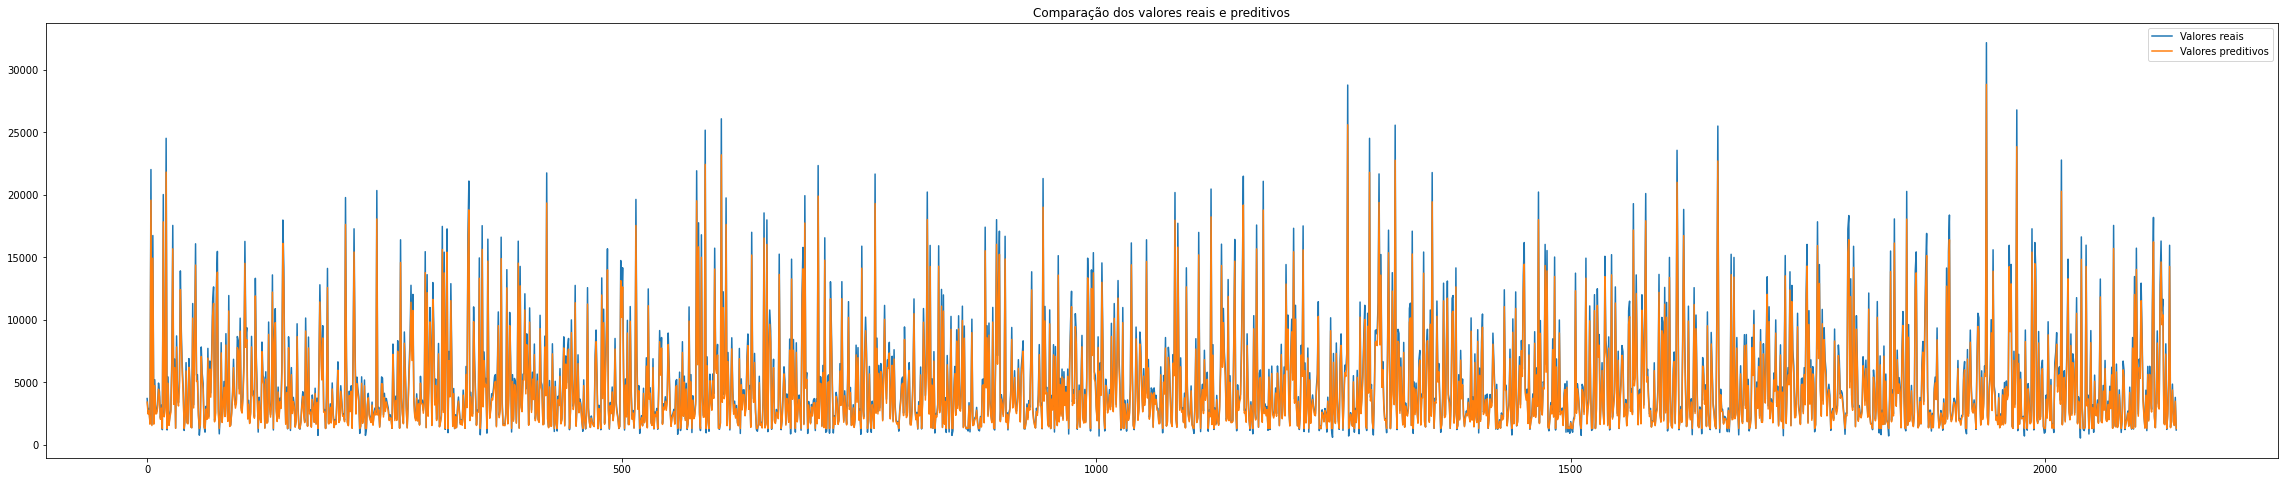

In [ ]:
plt.figure(figsize=(40,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Valores reais")
plt.plot(x_ax, y_pred, label="Valores preditivos")
plt.title("Comparação dos valores reais e preditivos")
plt.legend()
plt.show();

In [ ]:
import pickle

In [ ]:
with open("grid_kr.pkl", "wb") as f:
    pickle.dump(grid_kr, f)

INFO:tensorflow:Assets written to: ram:///tmp/tmpu1yx5wnl/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpu1yx5wnl/assets


In [ ]:
with open("grid_kr.pkl", "rb") as f:
    
    grid_kr = pickle.load(f)